In [57]:
!pip install matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [58]:
import h5py

dataset=None
timerange=None
freqrange=None
ids=None
fpath = '/project/lofarsw/Data/Dynspec/dset.h5'

with h5py.File(fpath, 'r') as fin:
  dataset=fin['/data'][:]
  timerange=fin['/time_range'][:]
  freqrange=fin['/freq_range'][:]
  ids=fin['timestamps'][:]
  


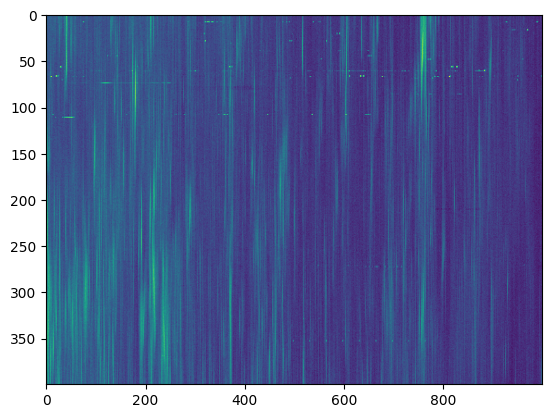

In [59]:
g = np.where(~np.isnan(dataset.sum(axis=(1,2))))
dataset = dataset[g]
timerange= timerange[g]
freqrange= freqrange[g]
ids = ids[g]
import matplotlib.pyplot as plt

dataset = dataset[:, :, 200:600]
plt.imshow(dataset[30, :, :].T, aspect='auto')
training_dset = dataset[::2, : ,:]  
validation_dset = dataset[1::2, :, :]

In [60]:
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
import tensorflow as tf
latent_dim = 512
batch_size = 32
train_size = int(training_dset.shape[0] * .8)
test_size = int(validation_dset.shape[0] * .8)
print('Batch size', batch_size, 'Train size', train_size, 'Test size', test_size)
print(training_dset.shape)
training_dset = training_dset[:, :training_dset.shape[1] // 4 * 4, :training_dset.shape[2] // 4 * 4].astype(np.float32)
validation_dset = validation_dset[:, :training_dset.shape[1] // 4 * 4, :training_dset.shape[2] // 4 * 4].astype(np.float32)
print(training_dset.shape)
new_shape = (training_dset.shape[0], training_dset.shape[1], training_dset.shape[2], 1)
training_dset = training_dset.reshape(new_shape)
validation_dset = validation_dset.reshape(new_shape)


train_dataset = (tf.data.Dataset.from_tensor_slices(training_dset).shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(validation_dset).shuffle(train_size).batch(batch_size))

Batch size 32 Train size 454 Test size 454
(568, 1000, 400)
(568, 1000, 400)


In [61]:
!pip install imageio
!rm -rf test
anim_file = 'test/cvae.gif'
import imageio
import glob
def create_gif(anim_file):
  if os.path.exists(anim_file):
    os.remove(anim_file)
  with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('test/image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
      image = imageio.imread(filename)
      writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

Epoch: 100, Test set ELBO: -39199.0625, time elapse for current epoch: 13.259408473968506


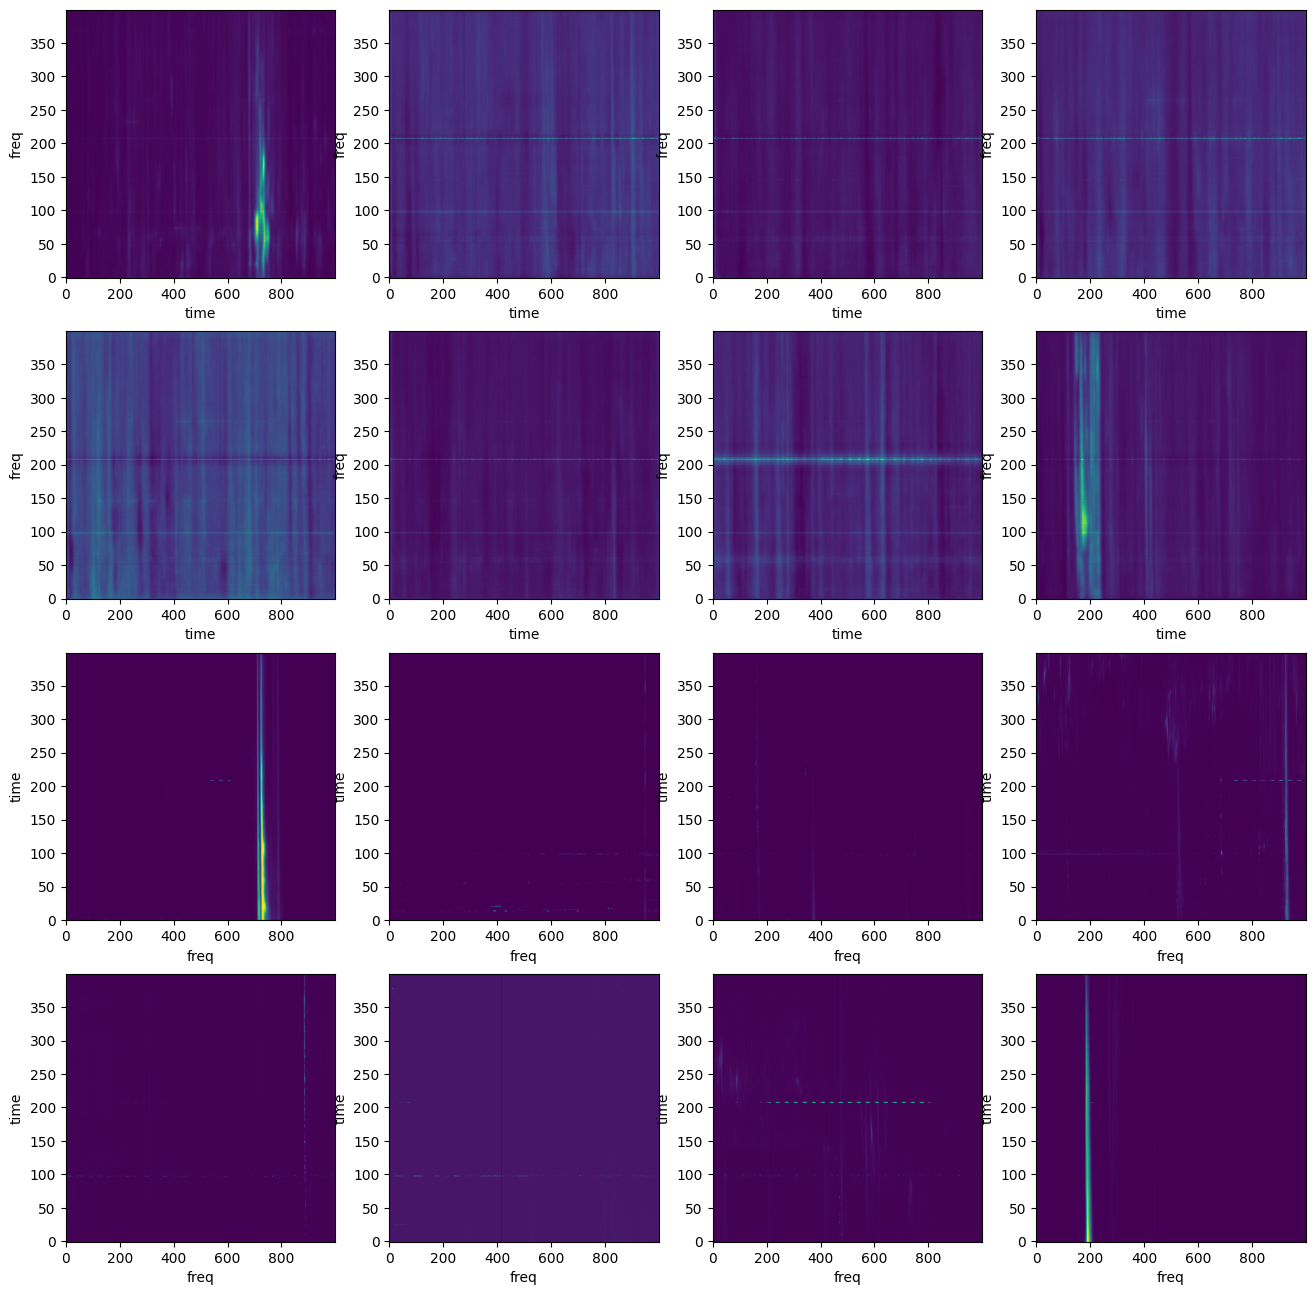

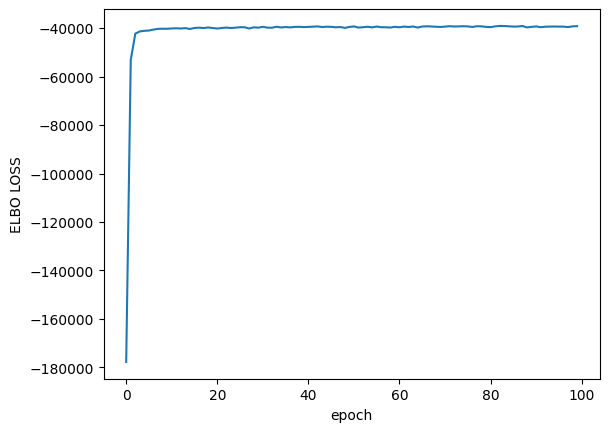

In [62]:
import time
from IPython import display

import os
class ConvVarAutoencoder(tf.keras.Model):
  def __init__(self, latent_dim, imsize):
    super().__init__(self)
    self.latent_dim = latent_dim
    shape = imsize
    self.encoder = tf.keras.Sequential(
      [
        tf.keras.layers.InputLayer(input_shape=imsize),
        tf.keras.layers.Conv2D(filters=32, kernel_size=(9,9), strides=(2, 2), activation='relu'),
        tf.keras.layers.Conv2D(filters=64, kernel_size=(9,9), strides=(2, 2), activation='relu'),
        tf.keras.layers.Conv2D(filters=64, kernel_size=(9,9), strides=(2, 2), activation='relu'),
        
        tf.keras.layers.Flatten(),
        # No activation
        tf.keras.layers.Dense(latent_dim + latent_dim),
      ]
    )
    rescaled = (shape[0] // 4, shape[1] // 4)
    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=rescaled[0]*rescaled[1]*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(rescaled[0], rescaled[1], 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64,  kernel_size=(9,9), strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=64,  kernel_size=(9,9), strides=2, padding='same',
                activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=(9,9), strides=1, padding='same'),
        ]
    )
  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits
  
optimizer = tf.keras.optimizers.Adam(1e-4)
def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

epochs = 100
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = ConvVarAutoencoder(latent_dim, training_dset.shape[1:])
os.makedirs('test', exist_ok=True)
def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(16, 16))

  for i in range(0, 8):
    plt.subplot(4, 4, i + 1)
    plt.imshow(np.array(predictions[i, :, :, 0]).T, cmap='viridis', origin='lower', aspect='auto')
    plt.xlabel('time')
    plt.ylabel('freq')
  for i in range(0, 8):
    plt.subplot(4, 4, i + 9)
    plt.imshow(np.array(test_sample[i, :, :, 0]).T, cmap='viridis', origin='lower', aspect='auto')
    plt.xlabel('freq')
    plt.ylabel('time')
  

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('test/image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]

generate_and_save_images(model, 0, test_sample)
elbo_loss = []
for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    train_step(model, train_x, optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    loss(compute_loss(model, test_x))
  elbo = -loss.result()
  elbo_loss.append(elbo)
  display.clear_output(wait=False)
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  generate_and_save_images(model, epoch, test_sample)
  create_gif(anim_file)
  
  plt.figure()
  plt.plot(elbo_loss)
  plt.ylabel('ELBO LOSS')
  plt.xlabel('epoch')
  plt.show()
  
  

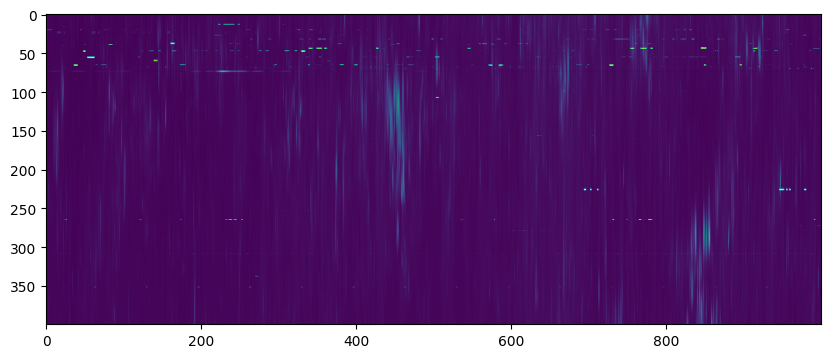

In [75]:

!mkdir -p model/convolutional_variational/
model.save_weights('model/convolutional_variational/17-03-2023.save')


#mean, logv = model.encode(training_dset[0])

(2, 512)


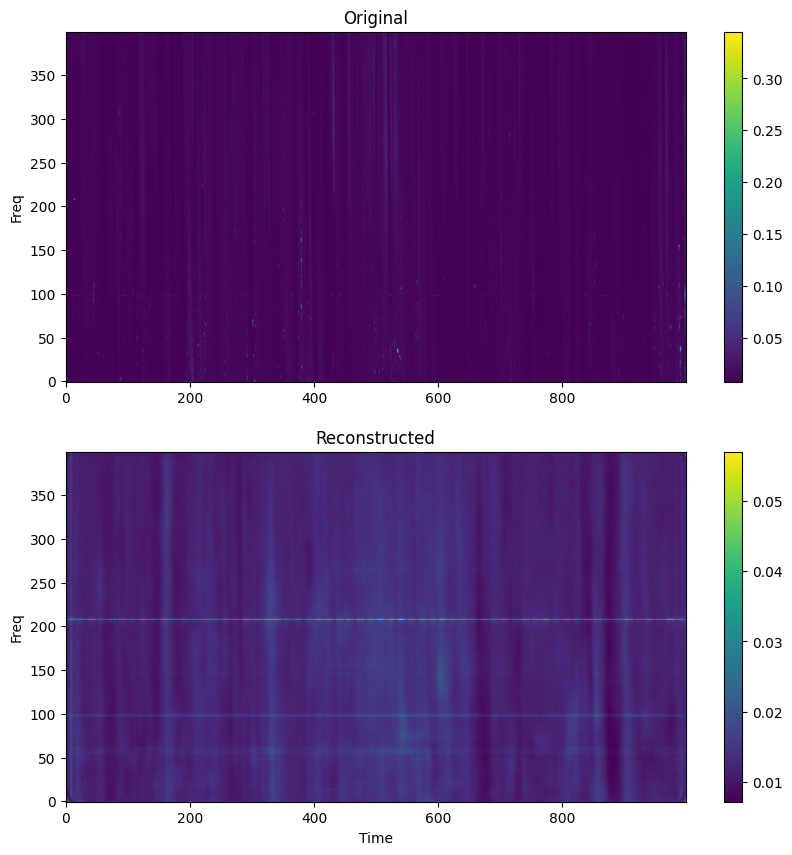

In [101]:
sample = 50


plt.figure('Comparison', (10, 10))
plt.subplot(2, 1, 1)
plt.ylabel('Freq')
plt.title('Original')
plt.imshow(training_dset[sample].T[0, :, :], origin='lower', aspect='auto')
plt.ylabel('Freq')
mean, logv = model.encode(training_dset[sample:sample+2])
z = model.reparameterize(mean, logv)
print(z.shape)
predictions = model.sample(z)
plt.colorbar()
plt.subplot(2,1,2)
plt.ylabel('Freq')
plt.xlabel('Time')
plt.title('Reconstructed')
plt.imshow(np.array(predictions[0,:, :]).T[0, :, :], origin='lower', aspect='auto')
plt.colorbar()



In [105]:

n_images = training_dset.shape[0]
z_final = np.zeros(training_dset.shape[0])
count = 0
b_size = 100

for i in range(0, n_images, b_size):
  
  mean, logv = model.encode(training_dset[count:count+b_size])
  z = model.reparameterize(mean, logv)
  if n_images + b_size > n_images:
    z_final[count:] = z
  else:
    z_final[count:b_size] = z
  

ValueError: could not broadcast input array from shape (100,512) into shape (568,)

In [69]:
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
import tensorflow as tf

latent_dim = 65

class Autoencoder(Model):
  def __init__(self, latency_dim, img_size):
    super(Autoencoder, self).__init__()

    self.img_size = img_size
    self.n_pixels = img_size[0] * img_size[1]
    
    self.latency_dim = latency_dim
    self.encoder = tf.keras.Sequential([
            layers.Flatten(),
            layers.Dense(latency_dim, activation='relu')
    ])

    self.decoder = tf.keras.Sequential(
        [
            layers.Dense(self.n_pixels, activation='sigmoid'),
            layers.Reshape(tuple(self.img_size))
        ]
    )
  def call(self, x):
    encoded = self.encoder(x)
    
    decoded = self.decoder(encoded)
    return decoded
print(validation_dset.shape[1:])
autoencoder = Autoencoder(latent_dim, validation_dset.shape[1:])

(1000, 600, 1)


In [70]:
training_dset.shape
validation_dset.shape

(568, 1000, 600, 1)

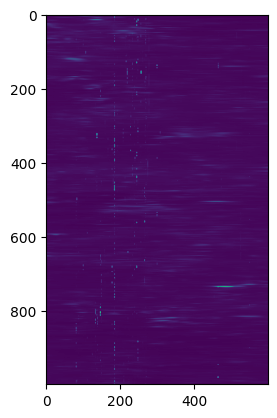

In [71]:
plt.imshow(validation_dset[0, :, :].astype(np.float32))

In [72]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
training_dset = training_dset.astype(np.float32)
validation_dset = training_dset.astype(np.float32)
autoencoder.fit(training_dset, training_dset,
                epochs=10,
                shuffle=True,
                validation_data=(validation_dset, validation_dset))

Epoch 1/10
18/18 [==============================] - 5s 240ms/step - loss: 0.1105 - val_loss: 0.0078
Epoch 2/10
18/18 [==============================] - 2s 94ms/step - loss: 0.0078 - val_loss: 0.0078
Epoch 3/10
18/18 [==============================] - 2s 96ms/step - loss: 0.0078 - val_loss: 0.0078
Epoch 4/10
18/18 [==============================] - 2s 101ms/step - loss: 0.0078 - val_loss: 0.0078
Epoch 5/10
18/18 [==============================] - 2s 92ms/step - loss: 0.0078 - val_loss: 0.0078
Epoch 6/10
18/18 [==============================] - 2s 96ms/step - loss: 0.0078 - val_loss: 0.0078
Epoch 7/10
18/18 [==============================] - 2s 99ms/step - loss: 0.0078 - val_loss: 0.0078
Epoch 8/10
18/18 [==============================] - 2s 96ms/step - loss: 0.0078 - val_loss: 0.0078
Epoch 9/10
18/18 [==============================] - 2s 96ms/step - loss: 0.0078 - val_loss: 0.0078
Epoch 10/10
18/18 [==============================] - 2s 97ms/step - loss: 0.0078 - val_loss: 0.0078


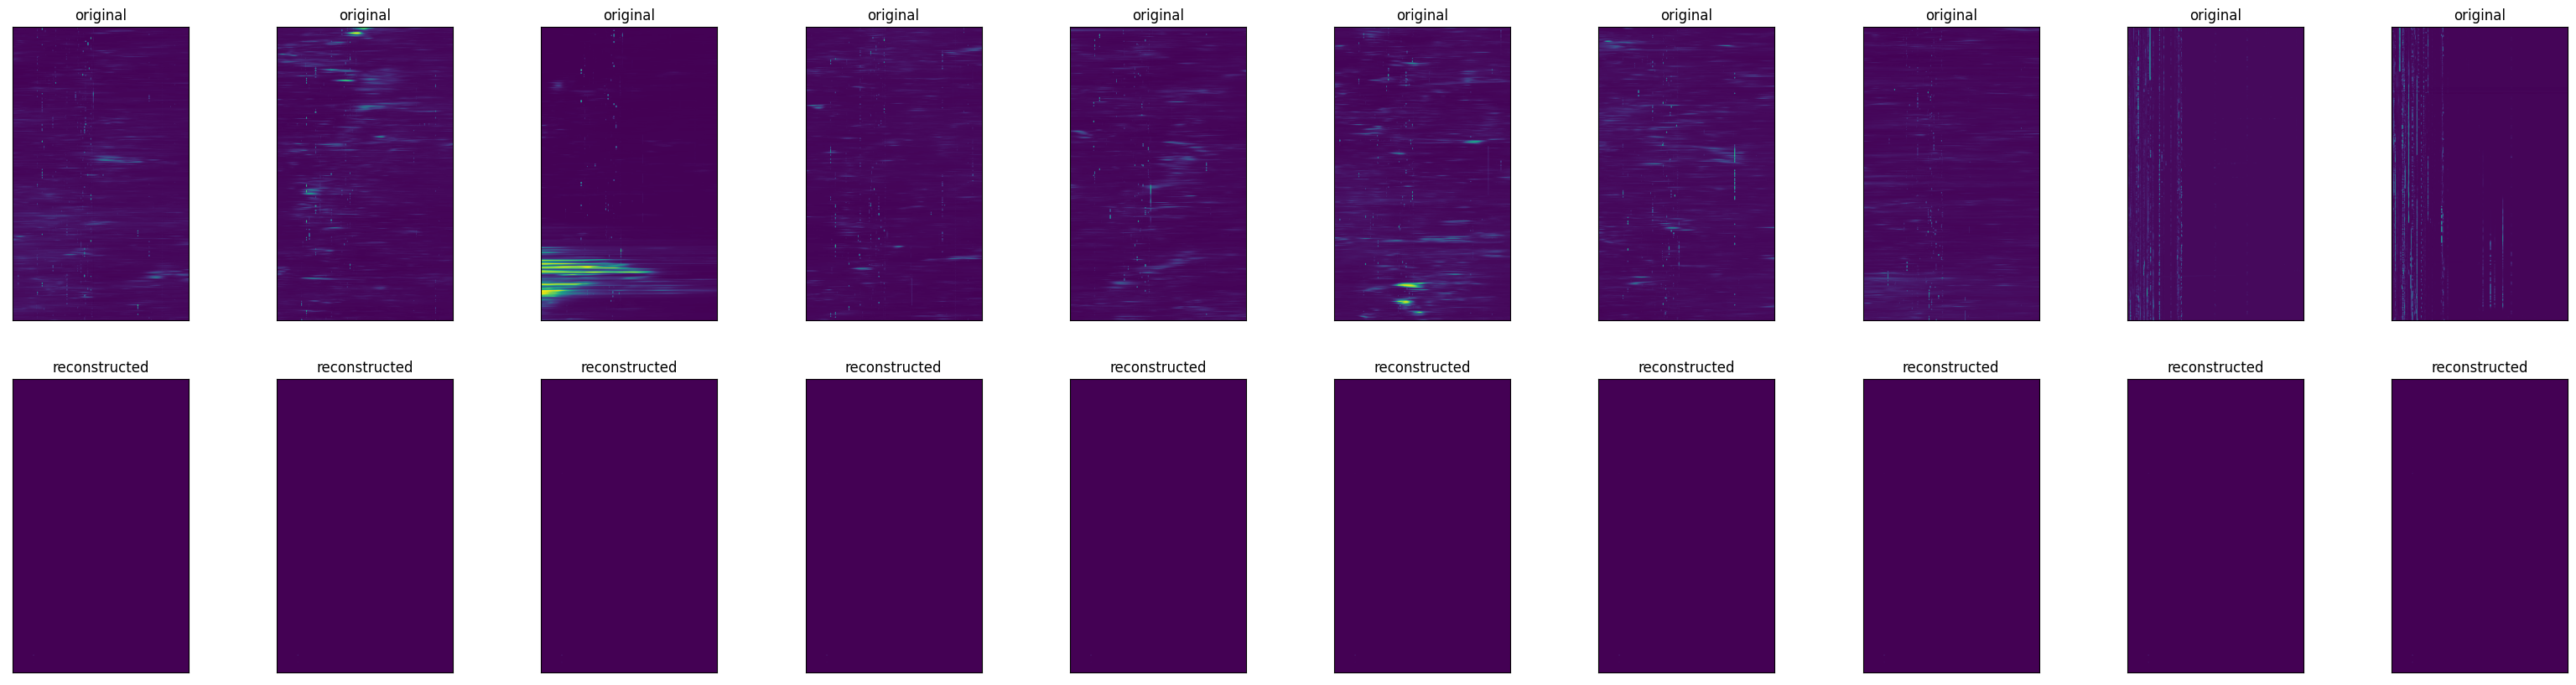

In [73]:
encoded_imgs = autoencoder.encoder(training_dset).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()
n = 10
plt.figure(figsize=(40, 10))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(training_dset[i], cmap='viridis')
  plt.title("original")
  
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i], cmap='viridis')
  plt.title("reconstructed")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5214 samples in 0.001s...
[t-SNE] Computed neighbors for 5214 samples in 0.657s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5214
[t-SNE] Computed conditional probabilities for sample 2000 / 5214
[t-SNE] Computed conditional probabilities for sample 3000 / 5214
[t-SNE] Computed conditional probabilities for sample 4000 / 5214
[t-SNE] Computed conditional probabilities for sample 5000 / 5214
[t-SNE] Computed conditional probabilities for sample 5214 / 5214
[t-SNE] Mean sigma: 0.831405
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.355648
[t-SNE] KL divergence after 1000 iterations: 0.299443


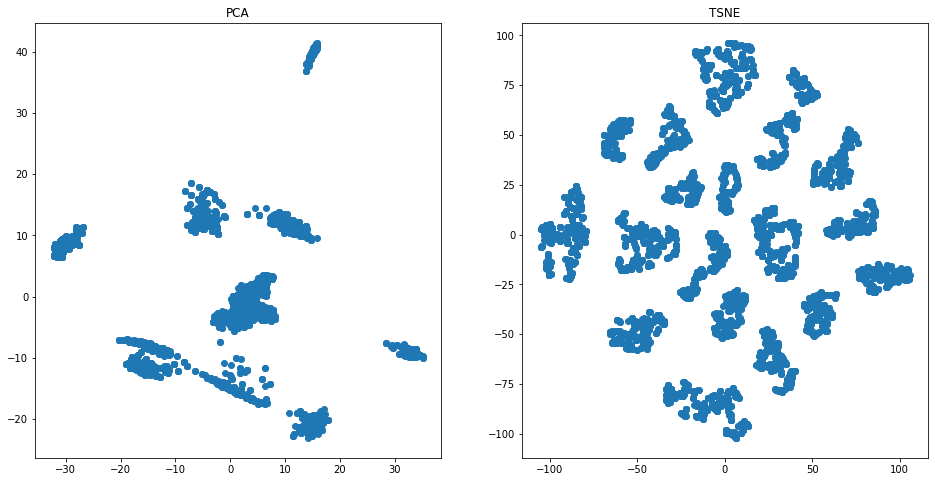

In [8]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
tsne = TSNE(2, verbose=1)
fig, [ax1,ax2] = plt.subplots(figsize=(16,8), nrows=1, ncols=2)

pca = PCA(n_components=2)
reduced = pca.fit_transform(encoded_imgs)
t = reduced.transpose()

tsne_reduced = tsne.fit_transform(encoded_imgs)
ts = tsne_reduced.transpose()
ax1.title.set_text('PCA')
ax1.scatter(t[0], t[1])

ax2.title.set_text('TSNE')
ax2.scatter(ts[0], ts[1])

plt.show()

In [9]:
### Find best clustering
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
sil = []
kmax = 30
ks = []
# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(5, kmax+1):
  ks.append(k)
  kmeans = KMeans(n_clusters = k).fit(encoded_imgs)
  labels = kmeans.labels_
  sil.append(silhouette_score(encoded_imgs, labels, metric = 'euclidean'))

Max score siluette is 11


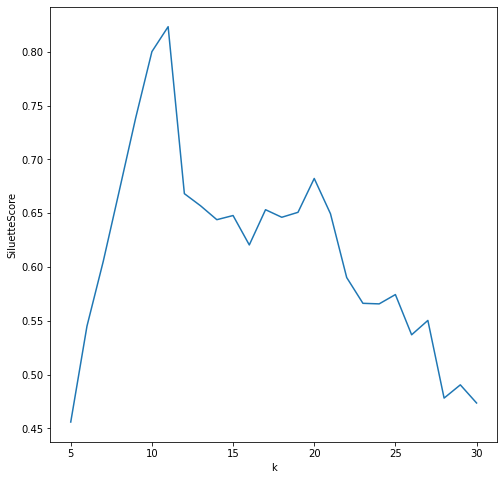

In [10]:
ks = np.array(ks)
sil = np.array(sil)
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(ks, sil)
ax.set_xlabel('k')
ax.set_ylabel('SiluetteScore')
g = np.where(sil==np.max(sil))[0][0]
best_k = ks[g]
print('Max score siluette is', best_k)

In [11]:
from sklearn.mixture import BayesianGaussianMixture

clusters = BayesianGaussianMixture(n_components=best_k, random_state=42).fit(encoded_imgs)
classes = clusters.predict(encoded_imgs)


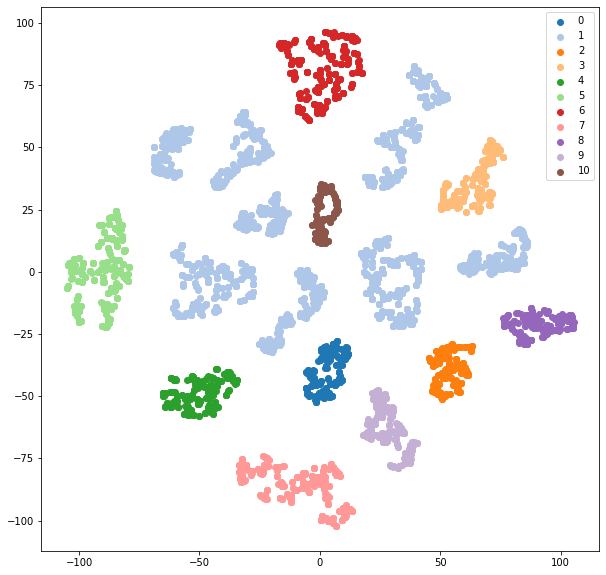

In [12]:
from matplotlib import cm
cmap = cm.get_cmap('tab20')
plt.subplots(figsize=(10, 10))
for k in range(best_k):
  classes_index = classes == k
  plt.scatter(
      tsne_reduced[classes_index, 0],
      tsne_reduced[classes_index, 1],
      c=np.array(cmap(k)).reshape(1, 4),
      label=k)
plt.legend()

In [14]:
import gc
import shutil
import os

if os.path.exists('/project/lofarsw/Public/bf_dynspec/classes'):
  shutil.rmtree('/project/lofarsw/Public/bf_dynspec/classes')
def plot_image(img, figname):
  plt.figure(figsize=(10, 10))
  plt.imshow(img, cmap='viridis')
  plt.xlabel('time')
  plt.ylabel('freq')
  plt.savefig(figname)
  plt.close('all')

for k in range(best_k):
  os.makedirs(f'/project/lofarsw/Public/bf_dynspec/classes/{k}', exist_ok=True)
  print('processing class', k)
  gc.collect()
  g = np.where(classes==k)[0]
  for index, gi in enumerate(g):
    print('Processing index', index)
    plot_image(training_dset[gi], f'/project/lofarsw/Public/bf_dynspec/classes/{k}/{gi}_plot.png')
    

processing class 0
Processing index 0
Processing index 1
Processing index 2
Processing index 3
Processing index 4
Processing index 5
Processing index 6
Processing index 7
Processing index 8
Processing index 9
Processing index 10
Processing index 11
Processing index 12
Processing index 13
Processing index 14
Processing index 15
Processing index 16
Processing index 17
Processing index 18
Processing index 19
Processing index 20
Processing index 21
Processing index 22
Processing index 23
Processing index 24
Processing index 25
Processing index 26
Processing index 27
Processing index 28
Processing index 29
Processing index 30
Processing index 31
Processing index 32
Processing index 33
Processing index 34
Processing index 35
Processing index 36
Processing index 37
Processing index 38
Processing index 39
Processing index 40
Processing index 41
Processing index 42
Processing index 43
Processing index 44
Processing index 45
Processing index 46
Processing index 47
Processing index 48
Processing 